In [2]:
!pip install discopy
import numpy as np
from discopy import Ob, Ty, Box, drawing, Id, Swap, Diagram, Functor, Dim, Tensor, Cup, Cap, tensor, Word, pregroup
# from discopy.quantum import qubit, H, Id, CX, QuantumGate, Ket, Bra, Measure, Discard, SWAP,  circuit, sqrt, X
# from pytket.extensions.qiskit import AerBackend, backends
# from pytket.extensions.qiskit.backends.ibm import job_monitor
# from pytket.extensions.qiskit.backends.ibm.IBMQ.ibmq import load_account

     |████████████████████████████████| 97 kB 4.4 MB/s 
  Created wheel for discopy: filename=discopy-0.3.6-py3-none-any.whl size=89689 sha256=10f1e1615c10eb20c476c7ff0ce340ebea8e930cb833736aa7994f6b79c19d1b
  Stored in directory: /root/.cache/pip/wheels/ec/1f/41/4b314f06f0b62fefe97735f6490f993874ae351bfdb0cafef0
Successfully built discopy


# Tensors as boxes

Sadly, Python is not very good at cooking, it doesn't even have a proper `coffee` module. There is one thing that Python's `numpy` module is good at though: computing with multi-dimensional arrays, a.k.a. **tensors**. We can interpret tensors as cooking steps with the dimensions of their axes as ingredients, i.e. **tensors are boxes**.

`Dim` (dimension) is a subclass of `Ty` where the objects are integers greater than 1, with multiplication as tensor and the unit dimension `Dim(1)`. `Tensor` is a subclass of `Box` defined by a pair of dimensions `dom, cod` and an `array` with shape `dom @ cod`.

In [ ]:
matrix = Tensor(Dim(2), Dim(2), [0, 1, 1, 0])

matrix.array

array([[0, 1],
       [1, 0]])

Composition is given by matrix multiplication, with `Tensor.id` as identity, e.g.

In [ ]:
assert matrix >> Tensor.id(Dim(2)) == matrix == Tensor.id(Dim(2)) >> matrix

vector = Tensor(Dim(1), Dim(2), [0, 1])

vector >> matrix

Tensor(dom=Dim(1), cod=Dim(2), array=[1, 0])

Tensor is given by the Kronecker product, with `Tensor.id(Dim(1))` as unit, e.g.

In [ ]:
assert Tensor.id(Dim(1)) @ matrix == matrix == matrix @ Tensor.id(Dim(1))

Tensor.id(Dim(1))

Tensor(dom=Dim(1), cod=Dim(1), array=[1.])

In [ ]:
vector @ vector

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[0, 0, 0, 1])

In [ ]:
vector @ matrix

Tensor(dom=Dim(2), cod=Dim(2, 2), array=[0, 0, 0, 1, 0, 0, 1, 0])

In practice, both composition and tensor are computed using `numpy.tensordot` and `numpy.moveaxis`.

In [ ]:
assert np.all(
    (matrix >> matrix).array == matrix.array.dot(matrix.array))
assert np.all(
    (matrix @ matrix).array == np.moveaxis(np.tensordot(
    matrix.array, matrix.array, 0), range(4), [0, 2, 1, 3]))

We can compute the conjugate transpose of a tensor using `[::-1]` (_dagger_).

In [ ]:
matrix = Tensor(Dim(2), Dim(2), [0, -1j, 2j, 0])
print(matrix.array)
matrix >> matrix[::-1]
print(matrix[::-1].array)

[[ 0.+0.j -0.-1.j]
 [ 0.+2.j  0.+0.j]]
[[ 0.-0.j  0.-2.j]
 [-0.+1.j  0.-0.j]]


In [ ]:
print(matrix.array)

[[ 0.+0.j -0.-1.j]
 [ 0.+2.j  0.+0.j]]


Thus, we can compute the inner product of two vectors as a scalar tensor.

In [ ]:
vector1 = Tensor(Dim(1), Dim(2), [-1j, 1j]) 

vector >> vector1[::-1]

Tensor(dom=Dim(1), cod=Dim(1), array=[0.-1.j])

We can add tensors elementwise, with the unit given by `Tensor.zeros`.

In [ ]:
vector + vector

Tensor(dom=Dim(1), cod=Dim(2), array=[0, 2])

In [ ]:
zero = Tensor.zeros(Dim(1), Dim(2))
assert vector + zero == vector == zero + vector

We can reorder the axes of the domain or codomain of a tensor by composing it with `Tensor.swap`.

In [ ]:
swap = Tensor.swap(Dim(2), Dim(3))

assert swap.dom == Dim(2) @ Dim(3) and swap.cod == Dim(3) @ Dim(2)
assert swap >> swap[::-1] == Tensor.id(Dim(2, 3))
assert swap[::-1] >> swap == Tensor.id(Dim(3, 2))

matrix1 = Tensor(Dim(3), Dim(3), list(range(9)))

assert vector @ matrix1 >> swap == matrix1 @ vector
assert swap >> matrix1 @ matrix >> swap[::-1] == matrix @ matrix1

In order to turn a domain axis into a codomain axis or vice-versa, we can "bend the legs" of a tensor up and down using `Tensor.cups` and `Tensor.caps`.

In [ ]:
cup, cap = Tensor.cups(Dim(2), Dim(2)), Tensor.caps(Dim(2), Dim(2))

print("cup == {}".format(cup))
print("cap == {}".format(cap))

cup == Tensor(dom=Dim(2, 2), cod=Dim(1), array=[1., 0., 0., 1.])
cap == Tensor(dom=Dim(1), cod=Dim(2, 2), array=[1., 0., 0., 1.])


In [ ]:
_id = Tensor.id(Dim(2))

assert cap @ _id >> _id @ cup == _id == _id @ cap >> cup @ _id

The assertion just above is called the **snake equation**. It is pretty hard to see where this name comes from if we just try to draw the equation. Indeed, all three sides of the equation are just `Tensor` boxes with some array inside:

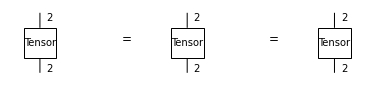

In [ ]:
drawing.equation(cap @ _id >> _id @ cup, _id, _id @ cap >> cup @ _id, figsize=(5, 1))

In order to draw a more meaningful equation, we need to draw diagrams, not boxes. We can use the special `Cup` and `Cap` boxes to draw bended wires.

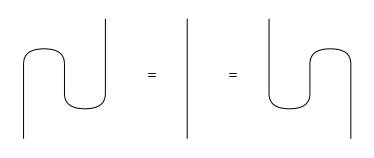

In [ ]:
left_snake = Cap(Dim(2), Dim(2)) @ Id(Dim(2)) >> Id(Dim(2)) @ Cup(Dim(2), Dim(2))
right_snake = Id(Dim(2)) @ Cap(Dim(2), Dim(2)) >> Cup(Dim(2), Dim(2)) @ Id(Dim(2))

drawing.equation(left_snake, Id(Dim(2)), right_snake, figsize=(5, 2), draw_type_labels=False)

Two diagrams that are drawn differently cannot be equal Python objects: they have different lists of boxes and offsets. What we can say however, is that the diagrams are interpreted as the same `Tensor` box. This interpretation can be computed using a `tensor.Functor`, defined by two mappings: `ob` from type to dimension (e.g. `qubit` to `Dim(2)`) and `ar` from box to array (e.g. `X` to `[0, 1, 1, 0]`). For now let's take these two mappings to be identity functions.

In [ ]:
_eval = tensor.Functor(
    ob=lambda x: x,
    ar=lambda f: f)

assert _eval(left_snake) == _eval(Id(Dim(2))) == _eval(right_snake)

A `tensor.Diagram`, also called a **tensor network**, is a subclass of `Diagram` equipped with such an `eval` method. A `tensor.Box`, also called a **node** in a tensor network, is a subclass of `Box` equipped with an attribute `array`. The evaluation a tensor diagram, i.e. the `tensor.Functor` that maps each box to its array, is also called **tensor contraction**.

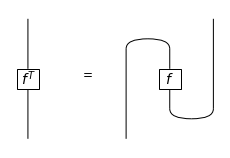

In [ ]:
f = tensor.Box("$f$", Dim(2), Dim(2), [1, 2, 3, 4])
f_T = tensor.Box("$f^T$", Dim(2), Dim(2), [1, 3, 2, 4])

diagram = tensor.Diagram(
    dom=Dim(2), cod=Dim(2),
    boxes=[Cap(Dim(2), Dim(2)), f, Cup(Dim(2), Dim(2))],
    offsets=[0, 1, 1])

drawing.equation(f_T, diagram, figsize=(3, 2), fontsize=14, draw_type_labels=False)

assert not f_T == diagram
assert f_T.eval() == diagram.eval()

The distinction between a `tensor.Diagram` and its interpretation as a `Tensor` is crucial. Indeed, two diagrams that evaluate to the same tensor may take very different times to compute. For example: 

In [ ]:
%timeit diagram.eval()

6.12 ms ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit f_T.eval()

232 µs ± 4.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Exercise:** Check out the [diagram rewriting](https://discopy.readthedocs.io/en/main/notebooks/rewriting-diagrams.html) notebook to learn how to remove snakes from a diagram. This can greatly speed up the evaluation of tensor diagrams!



In [ ]:
folder = lambda file: './imgs/' + file
# folder = lambda file: '../_static/imgs/' + file
params = dict(
    aspect='auto',
    loop=True,
    draw_type_labels=False)

In [ ]:
x = Ty('x')
copy, add = Box('copy', x, x @ x), Box('add', x @ x, x)
CX = copy @ Id(x) >> Id(x) @ add
XC = Id(x) @ copy >> add @ Id(x)
diagram = CX @ XC >> XC @ CX
rewrite_steps = diagram.normalize()

diagram.to_gif(*rewrite_steps,
               path=folder('simple-rewrite.gif'), **params)

In [ ]:
def spiral(n_cups):
    """
    Implements the asymptotic worst-case
    for normal_form, see arXiv:1804.07832.
    """
    x = Ty('x')
    unit, counit = Box('unit', Ty(), x), Box('counit', x, Ty())
    cup, cap = Box('cup', x @ x, Ty()), Box('cap', Ty(), x @ x)
    result = unit
    for i in range(n_cups):
        result = result >> Id(x ** i) @ cap @ Id(x ** (i + 1))
    result = result >> Id(x ** n_cups) @ counit @ Id(x ** n_cups)
    for i in range(n_cups):
        result = result >>\
            Id(x ** (n_cups - i - 1)) @ cup @ Id(x ** (n_cups - i - 1))
    return result


diagram = spiral(3)
diagram.to_gif(*diagram.normalize(),
               path=folder('spiral.gif'),
               **dict(params, draw_box_labels=False, loop=True, aspect='equal'))

In [ ]:
snake = Box('f', x @ x, x @ x)\
    .transpose(left=True).transpose(left=True)\
    .transpose().transpose()

snake.to_gif(*snake.normalize(), **params,
             path=folder('snake-removal.gif'))

## Exercise 2.1
Define a function that takes a number `n` and returns the diagram for a [matrix product state](https://en.wikipedia.org/wiki/Matrix_product_state) (MPS) with `n` particles and random entries. Check how the evaluation time scales with the size of the diagram. 



In [ ]:
# TODO

In [3]:
from discopy import Dim, Tensor,Cup, Cap
import numpy as np
def fun1(n):
  m = Tensor(Dim(2), Dim(2), np.random.random((2,2)))
  m1 = Tensor(Dim(2), Dim(2), np.random.random((2,2)))
  for i in range(1,n):
      m = m @ m1
  return m     

In [4]:
import time

time1=[]
for i in range(15):
  start = time.time()
  fun1(i)
  end = time.time()
  time1.append(end - start)

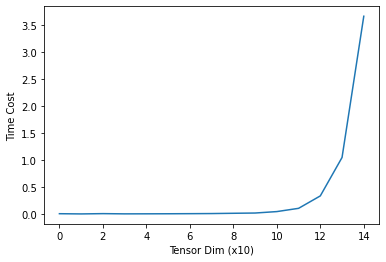

In [5]:
import matplotlib.pyplot as plt
plt.plot(list(time1))
plt.ylabel('Time Cost')
plt.xlabel('Tensor Dim (x10)')
plt.show()

## Exercise 2.2
Pip install the [tensornetwork](https://pypi.org/project/tensornetwork/) library and use it to contract the MPS diagrams more efficiently. This is done with the syntax `diagram.eval(contractor=tn.contractor.auto)`, see the [docs](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Diagram.html#discopy.tensor.Diagram.eval).

In [6]:
!pip install tensornetwork

     |████████████████████████████████| 363 kB 7.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [9]:
from numpy import random
import tensornetwork as tn
from discopy import tensor

In [40]:
vector = tensor.Box('vector', Dim(1), Dim(2), [0, 1])
assert (vector >> vector[::-1]).eval() == 1
assert (vector >> vector[::-1]).eval(tn.contractors.auto) == 1

vector1 = tensor.Box('vector1', Dim(1), Dim(2), [0, 1])
assert (vector1 >> vector1[::-1]).eval() == 1

In [46]:
def f(n):
  vectort=vector
  for i in range(1,n):
    vectort = vectort@vector
  return vectort
      


In [50]:
time1=[]
time2=[]
for i in range(30):
  start = time.time()
  assert (f(i) >> f(i)[::-1]).eval(tn.contractors.auto) == 1
  end = time.time()
  time1.append(end - start)

  start = time.time()
  assert (f(i) >> f(i)[::-1]).eval() == 1
  end = time.time()
  time2.append(end - start)


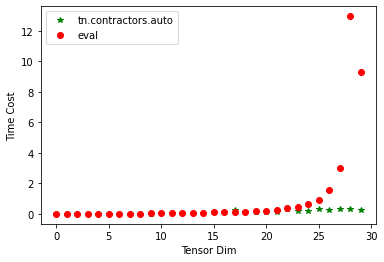

In [51]:
import matplotlib.pyplot as plt
plt.plot(time1,'g*', time2, 'ro')
plt.ylabel('Time Cost')
plt.xlabel('Tensor Dim')
plt.legend(['tn.contractors.auto','eval'])
plt.show()

## References

* Coecke, B., Sadrzadeh, M., & Clark, S. (2010) _Mathematical foundations for a compositional distributional model of meaning._ [arXiv:1003.4394](https://arxiv.org/abs/1003.4394)
* Zeng, W., & Coecke, B.  (2016) _Quantum algorithms for compositional natural language processing._ [arXiv:1608.01406](https://arxiv.org/abs/arXiv:1608.01406)
* de Felice, G., Toumi, A., & Coecke, B. (2020) _DisCoPy: Monoidal Categories in Python._ [arXiv:2005.02975](https://arxiv.org/abs/2005.02975)
* Meichanetzidis, K., Toumi, A., de Felice, G., & Coecke, B. (2020) _Grammar-Aware Question-Answering on Quantum Computers._ [arXiv:2012.03756](https://arxiv.org/abs/arXiv:2012.03756)
* Meichanetzidis, K., Gogioso, S., De Felice, G., Chiappori, N., Toumi, A., & Coecke, B. (2020) _Quantum natural language processing on near-term quantum computers._ [arXiv:2005.04147](https://arxiv.org/abs/arXiv:2005.04147)